<a href="https://colab.research.google.com/github/taufiq-ai/JCTA-ALL/blob/main/jcta_all_mobilenetv2_notebook_MAY24_V4_Acc97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import os
import math
import shutil
import glob
import numpy as np
import random
import subprocess
import json
# from tqdm import tqdm
from tqdm.notebook import tqdm
from io import StringIO
from contextlib import redirect_stdout, redirect_stderr
# from google.colab import userdata

import keras
import tensorflow
from tensorflow.keras.utils import load_img, img_to_array
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model, load_model
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Data Fetch and Split

In [2]:
# Save Kaggle Credentials, when you use a plartform other than kaggle

kaggle_username = "taufiqtusar"
kaggle_api_key = "bb02eeedd895522b3e1faedde8e7253f"

kaggle_json = {"username": f"{kaggle_username}", "key":f"{kaggle_api_key}"}
with open('kaggle.json', 'w') as file_out:
    json.dump(kaggle_json, file_out)
    file_out.close()


# fetch kaggle dataset
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download mehradaria/leukemia # Download Dataset
! unzip leukemia.zip # Unzip

Streaming output truncated to the last 5000 lines.
  inflating: Original/Pre/WBC-Malignant-Pre-024.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-025.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-026.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-027.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-028.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-029.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-030.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-031.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-032.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-033.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-034.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-035.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-036.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-037.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-038.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-039.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-040.jpg  
  inflating: Original/Pre/WBC-M

## Data Pre-processors

In [3]:
def copy_directory(root_dir: str, copy_of_root_dir: str) -> None:
    """
    Copy the entire directory tree from 'root_dir' to 'copy_of_root_dir'.
    If 'copy_of_root_dir' already exists, it will be deleted before copying.
    """
    if os.path.exists(copy_of_root_dir):
        delete_dir(copy_of_root_dir)
    shutil.copytree(root_dir, copy_of_root_dir)


def get_dataset_structure(root_dir: str) -> dict:
    """
    Traverse through 'root_dir' and its class folders, counting the data in each class.
    Return a dictionary with class name as 'key' and json value with data count and list of img paths.
    """
    dirs = os.listdir(root_dir)
    dataset_structure = {}
    for dir_name in dirs:
        number_of_files = len(os.listdir(os.path.join(root_dir, dir_name)))
        list_of_file_paths = os.listdir(os.path.join(root_dir, dir_name))
        dataset_structure[dir_name] = {
            "number_of_files": number_of_files,
            "list_of_file_paths": list_of_file_paths,
        }
        print(f"get_dataset_structure - dir: {dir_name}, number_of_files: {number_of_files}")

    return dataset_structure

def count_total_data_in_a_split(dir_path: str) -> None:
    count = 0
    dirs = os.listdir(dir_path)

    for dir_name in dirs:
        number_of_files = len(os.listdir(os.path.join(dir_path, dir_name)))
        count+=number_of_files
        # print(f"directory: {dir_path}, number_of_files: {number_of_files}")

    print(f"directory: {dir_path}, count: {count}")



def shuffle_list(list_of_paths: list) -> list:
    random.shuffle(list_of_paths)
    return list_of_paths


def split_list(list_of_paths: list, threshold: float) -> list:
    """    Split the list of paths into two parts based on the given threshold.
    """
    split_index = int(len(list_of_paths) * threshold)
    splitted_list = list_of_paths[:split_index]
    fresh_list = list_of_paths[split_index:]
    return splitted_list, fresh_list


def copy_file(path_to_copy: str, path_to_paste: str) -> None:
    subprocess.run(["cp", path_to_copy, path_to_paste])

def move_file(path_to_move: str, path_to_destination: str) -> None:
#     shutil.move(path_to_move, path_to_destination)
    subprocess.run(["cp", path_to_move, path_to_destination])


def create_dir(path_to_new_dir: str) -> None:
    if os.path.exists(path_to_new_dir):
        delete_dir(path_to_new_dir)
    os.mkdir(path_to_new_dir)


def delete_dir(path_to_dir: str) -> None:
    shutil.rmtree(path_to_dir)


### Implement split

In [4]:
### Create train-val-test dirs

# specify correct paths
train_path = '/content/train'
val_path = '/content/val'
test_path = '/content/test'
safe_root_dir = "/content/Original"
root_dir = "/content/Original_Copy"

dirs = [train_path, val_path, test_path]
classes = [
    "Benign",
    "Early",
    "Pre",
    "Pro",
]

for dir in dirs:
    create_dir(dir)
    for class_name in classes:
        create_dir(dir+"/"+class_name)


# split dir
root_dir = safe_root_dir
# copy_directory(root_dir=safe_root_dir, copy_of_root_dir=root_dir)
dataset_structure = get_dataset_structure(root_dir)


for key, val in dataset_structure.items():
    number_of_files = dataset_structure[key]["number_of_files"]
    list_of_file_paths = dataset_structure[key]["list_of_file_paths"]
    print(f"\nclass: {key}, count: {number_of_files}")

    # shuffle
    list_of_file_paths = shuffle_list(list_of_file_paths)

    # split 70% into training data
    splitted_list, fresh_list = split_list(list_of_paths=list_of_file_paths, threshold=.7)
    print(f"train split: {len(splitted_list)}")
    for filename in splitted_list:
        source_file_path = f"{root_dir}/{key}/{filename}"
        dest_file_path = f"{train_path}/{key}/{filename}"
        move_file(
            path_to_move=source_file_path,
            path_to_destination=dest_file_path,
        )

    # split rest 50% into val data
    splitted_list, fresh_list = split_list(list_of_paths=fresh_list, threshold=.5)
    print(f"val split: {len(splitted_list)}")
    for filename in splitted_list:
        source_file_path = f"{root_dir}/{key}/{filename}"
        dest_file_path = f"{val_path}/{key}/{filename}"
        move_file(
            path_to_move=source_file_path,
            path_to_destination=dest_file_path,
        )


    # split rest into test data
    splitted_list, fresh_list = split_list(list_of_paths=fresh_list, threshold=1)
    print(f"test split: {len(splitted_list)}")
    for filename in splitted_list:
        source_file_path = f"{root_dir}/{key}/{filename}"
        dest_file_path = f"{test_path}/{key}/{filename}"
        move_file(
            path_to_move=source_file_path,
            path_to_destination=dest_file_path,
        )


# Verify split
print("\n\n")
for dir in dirs:
    count_total_data_in_a_split(dir)

get_dataset_structure - dir: Benign, number_of_files: 504
get_dataset_structure - dir: Early, number_of_files: 985
get_dataset_structure - dir: Pre, number_of_files: 963
get_dataset_structure - dir: Pro, number_of_files: 804

class: Benign, count: 504
train split: 352
val split: 76
test split: 76

class: Early, count: 985
train split: 689
val split: 148
test split: 148

class: Pre, count: 963
train split: 674
val split: 144
test split: 145

class: Pro, count: 804
train split: 562
val split: 121
test split: 121
directory: /content/train, count: 2277
directory: /content/val, count: 489
directory: /content/test, count: 490


# Data Preparation for Model


In [5]:
# Define data generators with aggressive data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 2277 images belonging to 4 classes.
Found 489 images belonging to 4 classes.


# MobileNetV2

In [6]:
# Downloading MobileNet model
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable = False

# Adding custom dense layers with increased complexity
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(4, activation='softmax')(x)

model = Model(base_model.input, x)

# Compile the model with a lower learning rate
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [7]:
import tensorflow as tf
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

filepath="bestmodel.keras"

# Define callbacks for model checkpointing and early stopping
mc = ModelCheckpoint(filepath=filepath,
                     monitor="val_accuracy",
                     verbose=1,
                     save_best_only=True)

es = EarlyStopping(monitor="val_loss",
                   min_delta=0.01,
                   patience=6,
                   verbose=1)

# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[mc, es]
)

GPU is available
Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 6.9271 - accuracy: 0.4944
Epoch 1: val_accuracy improved from -inf to 0.80417, saving model to bestmodel.keras
71/71 [==============================] - 42s 456ms/step - loss: 6.9271 - accuracy: 0.4944 - val_loss: 0.3983 - val_accuracy: 0.8042
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 0.9738 - accuracy: 0.6882
Epoch 2: val_accuracy did not improve from 0.80417
71/71 [==============================] - 29s 415ms/step - loss: 0.9738 - accuracy: 0.6882 - val_loss: 0.6014 - val_accuracy: 0.8042
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.7746
Epoch 3: val_accuracy improved from 0.80417 to 0.87083, saving model to bestmodel.keras
71/71 [==============================] - 35s 490ms/step - loss: 0.6376 - accuracy: 0.7746 - val_loss: 0.3105 - val_accuracy: 0.8708
Epoch 4/100
71/71 [==============================] - ETA: 0s - loss: 0.4847 - 

## Show Graph

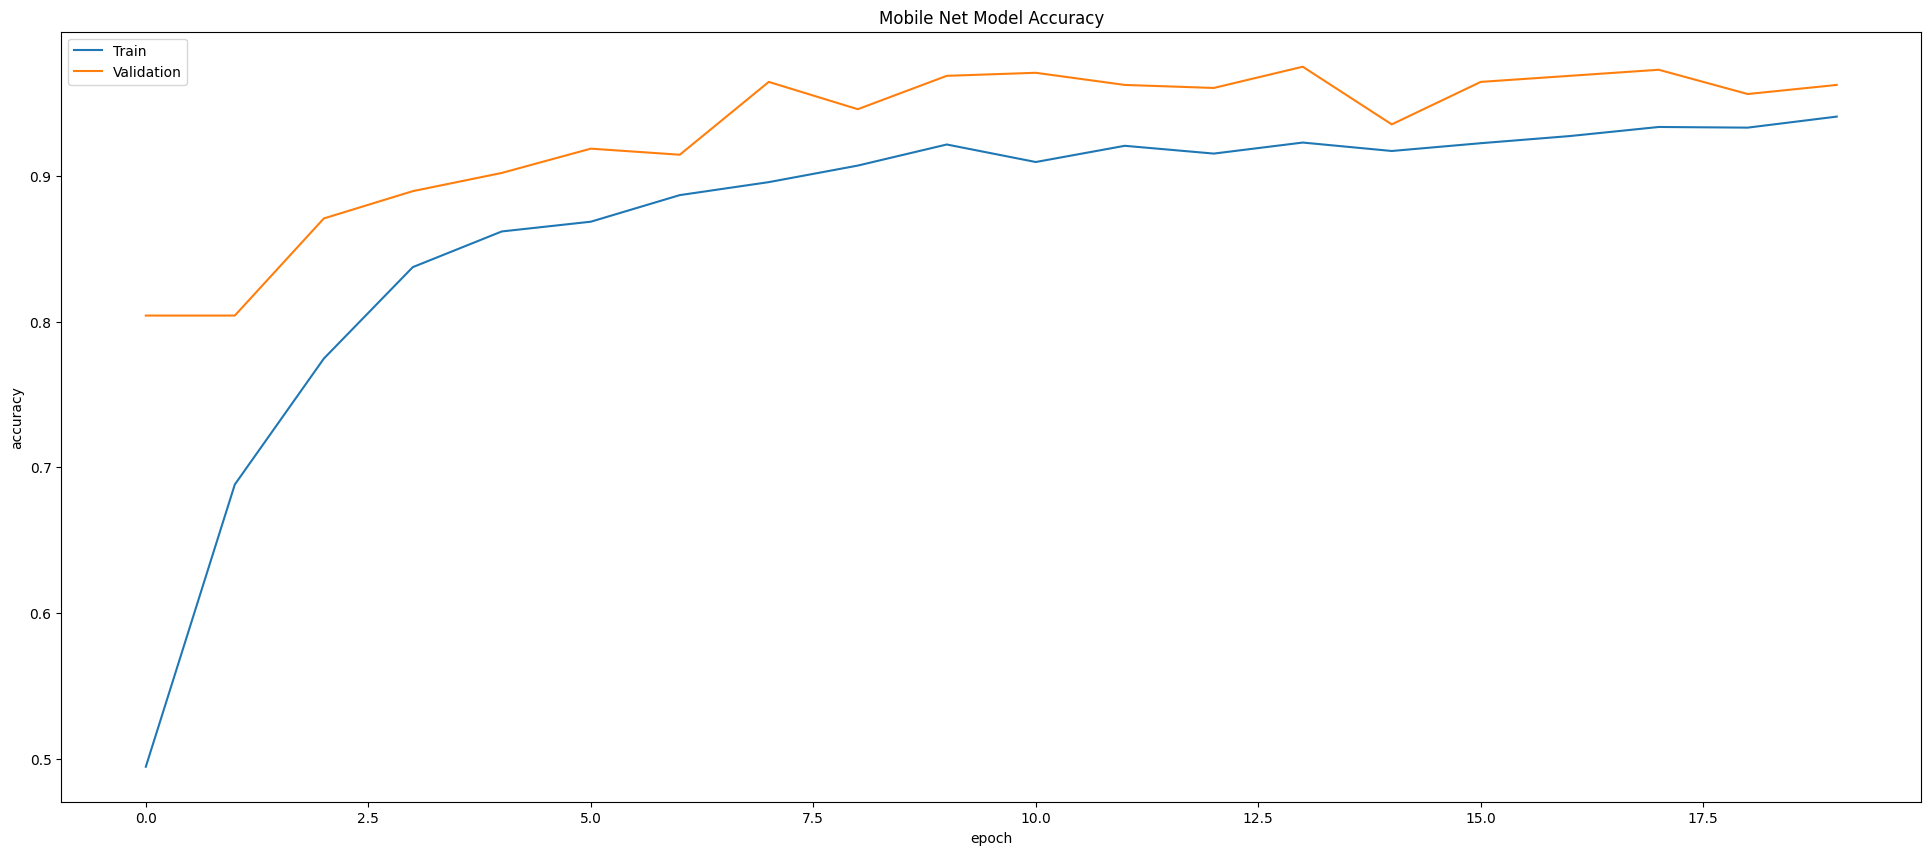

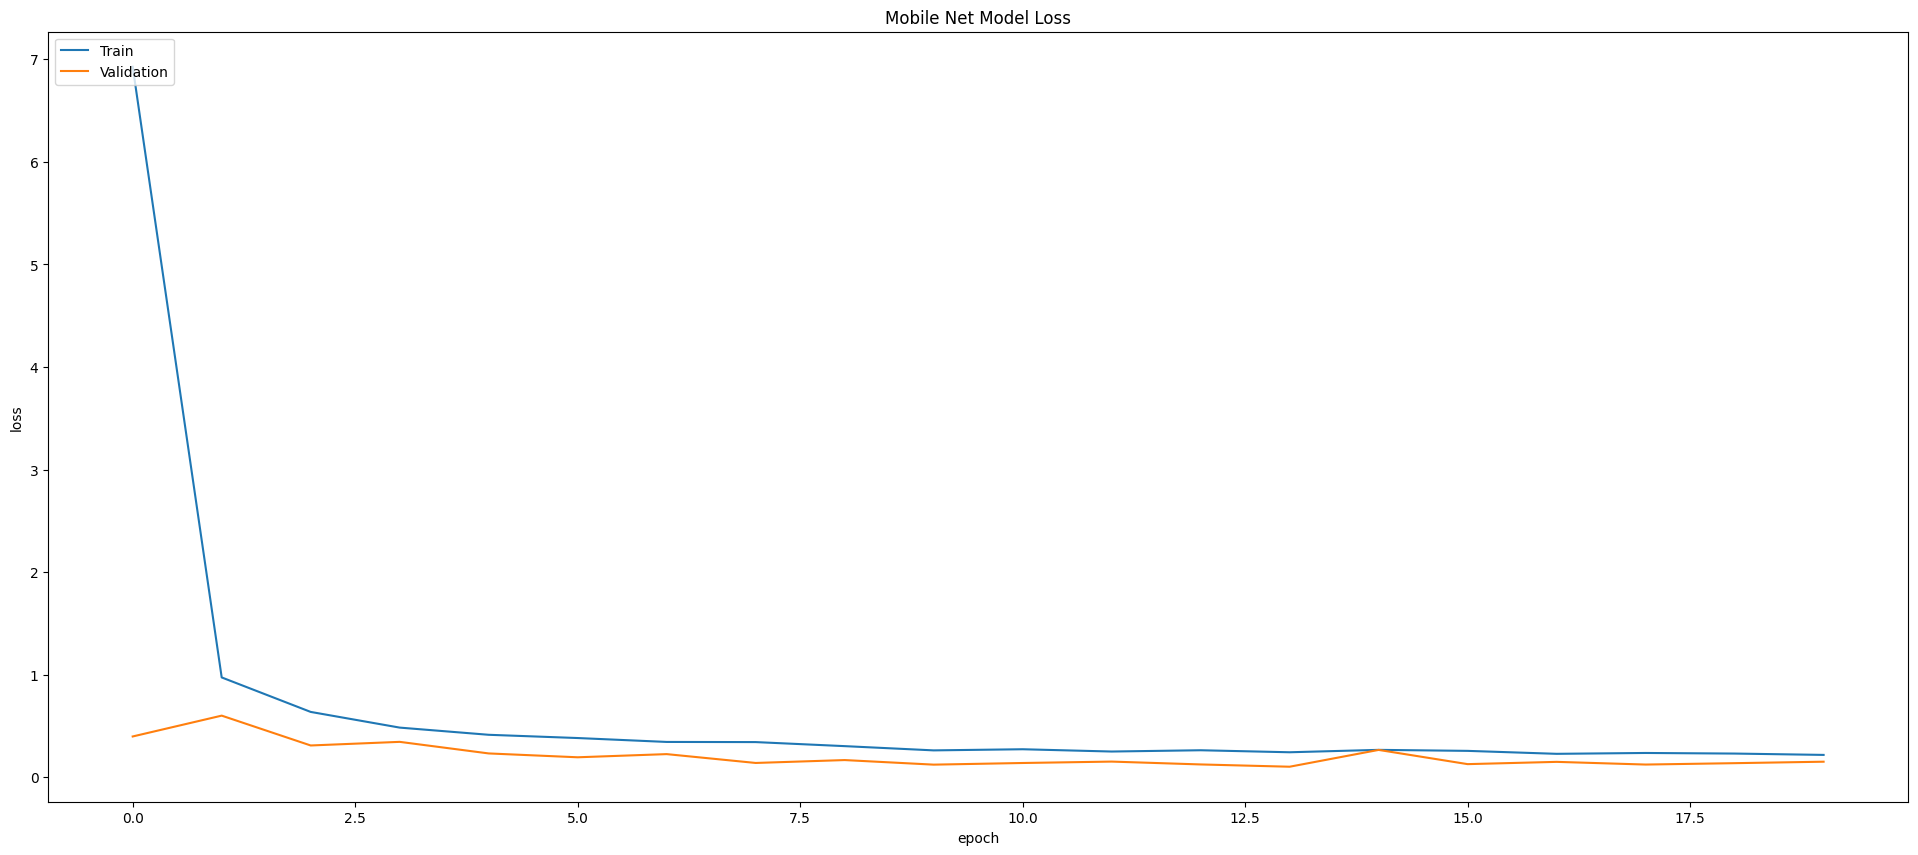

In [8]:
# summarize history for accuracy --- SAVE
plt.figure(figsize=(24, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Mobile Net Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("MobileNet_Accuracy2.png")
plt.show()

# summarize history for loss --- SAVE
plt.figure(figsize=(24, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Mobile Net Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("MobileNet_Validation2.png")
plt.show()

# Evaluation

In [9]:
best_model_path = "/content/bestmodel.keras"
model = load_model(best_model_path)

## GPU Evaluation (Generator Based)

In [10]:
## Confusion Matrix & Classification Report
def generate_conf_matrix_report_gpu(y: list, y_pred: list):

    true_labels = y
    predicted_labels = y_pred

    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    class_report = classification_report(true_labels, predicted_labels)

    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

    # Manusal Accuracy
    wrong = 0
    for y, y_pred in zip(true_labels, predicted_labels):
        if y != y_pred:
            wrong+=1
    count = len(true_labels)
    correct = count - wrong
    accuracy = (correct/count)*100
    print(f"\nAccuracy: {accuracy}\n")


    # Plot confusion matrix
    print("Plot: \n\n")
    class_names = ['Benign', 'Early', 'Pre', 'Pro']
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


def get_predict_from_test_generator(test_generator, model):
    """
    Generate predictions from a test generator and store the results in a dictionary.

    Args:
    - test_generator: A generator yielding batches of test data.
    - model: The trained model used for prediction.

    Returns:
    - test_result: A dictionary containing the ground truth labels, predictions,
      and additional information for each sample in the test dataset.
    """
    test_result = {
        "ground_truth": [],
        "prediction": [],
        "y_true": [],
        "y_pred": [],
        "confidence": []
    }

    pbar = tqdm(total=len(test_generator), desc="Predicting")

    # Suppress output/log messages during prediction
    with redirect_stdout(StringIO()), redirect_stderr(StringIO()):

        # Iterate over the test generator
        for i in range(len(test_generator)):
            batch = test_generator[i]
            images, labels = batch

            # Iterate over each image in the batch
            for j in range(len(images)):
                image = images[j]
                label = labels[j]  # e.g., [0. 0. 1. 0.]
                label_class_index = np.argmax(label)  # e.g., 2

                # Perform prediction using the model
                prediction = model.predict(np.expand_dims(image, axis=0))  # e.g., [[0.002 0.003 0.994 0.001]]
                predicted_class_index = np.argmax(prediction)  # e.g., 2
                predicted_class_probability = prediction[0][predicted_class_index]  # e.g., 0.994

                # Store ground truth label, predicted label, and confidence
                test_result["ground_truth"].append(label)
                test_result["prediction"].append(prediction)
                test_result["y_true"].append(label_class_index)
                test_result["y_pred"].append(predicted_class_index)
                test_result["confidence"].append(predicted_class_probability)

            pbar.update(1)
        pbar.close()

    return test_result


In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical'
)

Found 490 images belonging to 4 classes.


Predicting:   0%|          | 0/490 [00:00<?, ?it/s]

Confusion Matrix:
[[ 65   7   0   4]
 [  3 144   1   0]
 [  0   1 144   0]
 [  1   0   0 120]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        76
           1       0.95      0.97      0.96       148
           2       0.99      0.99      0.99       145
           3       0.97      0.99      0.98       121

    accuracy                           0.97       490
   macro avg       0.96      0.95      0.96       490
weighted avg       0.97      0.97      0.96       490


Accuracy: 96.53061224489797

Plot: 




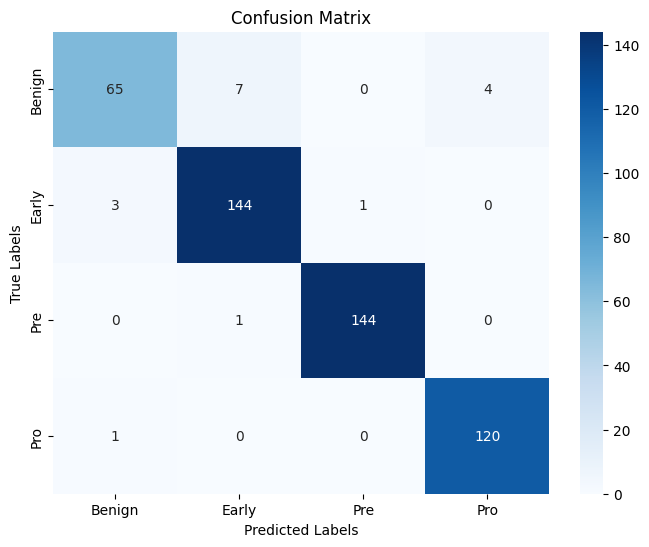

In [12]:
# Get predictions from the test generator
test_result = get_predict_from_test_generator(test_generator, model)

# Generate classification report
generate_conf_matrix_report_gpu(y=test_result["y_true"], y_pred=test_result["y_pred"])

In [13]:
test_result

{'ground_truth': [array([0., 0., 1., 0.], dtype=float32),
  array([0., 1., 0., 0.], dtype=float32),
  array([0., 0., 0., 1.], dtype=float32),
  array([0., 0., 0., 1.], dtype=float32),
  array([0., 1., 0., 0.], dtype=float32),
  array([0., 0., 0., 1.], dtype=float32),
  array([0., 0., 1., 0.], dtype=float32),
  array([0., 0., 1., 0.], dtype=float32),
  array([1., 0., 0., 0.], dtype=float32),
  array([0., 0., 0., 1.], dtype=float32),
  array([0., 0., 0., 1.], dtype=float32),
  array([0., 0., 1., 0.], dtype=float32),
  array([0., 0., 0., 1.], dtype=float32),
  array([0., 1., 0., 0.], dtype=float32),
  array([0., 0., 1., 0.], dtype=float32),
  array([0., 0., 1., 0.], dtype=float32),
  array([0., 0., 0., 1.], dtype=float32),
  array([1., 0., 0., 0.], dtype=float32),
  array([1., 0., 0., 0.], dtype=float32),
  array([0., 1., 0., 0.], dtype=float32),
  array([1., 0., 0., 0.], dtype=float32),
  array([0., 0., 0., 1.], dtype=float32),
  array([0., 0., 1., 0.], dtype=float32),
  array([0., 0., 1

## CPU Evaluation without Batch

In [ ]:
def predict(path, best_model_path: str) -> str:

  model = load_model(best_model_path)

  img = load_img(path, target_size=(224,224))
  input_arr = img_to_array(img)/255
  input_arr = np.array([input_arr])

  pred = np.argmax(model.predict(input_arr))

  if pred == 0:
    return 'Benign'
  elif pred == 1:
    return 'Early'
  elif pred == 2:
    return 'Pre'
  elif pred == 3:
    return 'Pro'


def generate_y_and_y_pred(path, best_model_path) -> list:
    y = path.split('/')[-2]
    y_pred = predict(path, best_model_path)
    return [y, y_pred]


def get_paths_list(folder_path) -> list:
    paths_list = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            paths_list.append(file_path)
    return paths_list


def list_all_y_and_y_preds(DIR_PATH, best_model_path) -> list:
    test_files = get_paths_list(DIR_PATH)
    result_list = []
    for test_image_path in test_files:
        y_and_y_pred = generate_y_and_y_pred(test_image_path, best_model_path)
        # print(y_and_y_pred)
        result_list.append(y_and_y_pred)
    return result_list


def generate_conf_matrix_report(result_list: list):
    # Extract true labels and predicted labels from result_list
    true_labels = [item[0] for item in result_list]
    predicted_labels = [item[1] for item in result_list]

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Generate classification report
    class_report = classification_report(true_labels, predicted_labels)

    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

    class_names = ['Benign', 'Early', 'Pre', 'Pro']

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
# result_list = list_all_y_and_y_preds(test_path, best_model_path)

In [ ]:
# generate_conf_matrix_report(result_list)

# Test a specific Kaggle Model



## MobileNetV2 - 32M - 92Acc - 29 April 2024 varient

In [ ]:
# # Load Model
# mobilenetv2_32m_acc92_model_path = "/kaggle/input/jcta_all_mobilenetv2_acc92.keras/keras/32m-29april2024/1/bestmodel.keras"
# model = load_model(mobilenetv2_32m_acc92_model_path)

# # Get predictions from the test generator
# test_result = get_predict_from_test_generator(test_generator, model)


In [ ]:
# Generate classification report
# generate_conf_matrix_report_gpu(y=test_result["y_true"], y_pred=test_result["y_pred"])